# Introduction
This tutorial illustrates how to study (1), (2)

In [1]:
import os
import pandas as pd;
import numpy as np
import opendssdirect as dss
import matplotlib as plt
os.chdir('C:\\Users\\TAM048\\Desktop\\Opendss\\Jupyter project\\Tutorial 4 Time series simulation') 
dss.Basic.AllowEditor(False)

### (1) 

In [3]:
dss.run_command('Redirect simple_load_profile.dss')
dss.run_command('Export monitor m1');#get active and reactive power
dss.run_command('Export monitor m2');#get apparent power
dss.run_command('Export monitor m3');#get voltages

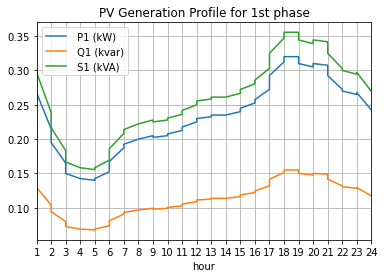

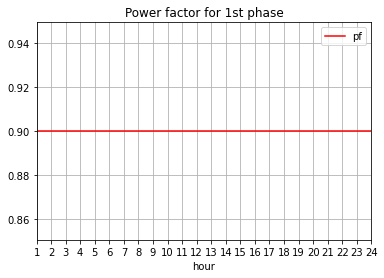

In [5]:
def power_plot():
    #Read the csv files
    m1_data=pd.read_csv("TheveninEquivalent_Mon_m1.csv",header=0);
    m2_data=pd.read_csv("TheveninEquivalent_Mon_m2.csv",header=0);

    #Stores 1st-phase power information in array
    t=m1_data['hour']; #x-axis, time in hour
    P1=m1_data[' P1 (kW)']; #active power
    Q1=m1_data[' Q1 (kvar)'] #reactive power
    S1=m2_data[' S1 (kVA)'] #apparent power
    pf=round(P1/S1,2); #power factor

    df=[t,P1,Q1,S1]
    df=(pd.DataFrame(df)).T
    df['pf']=pf
    #print(pf)  #uncomment if you want to see how pf changes with time

    #plot the dataframe
    df.plot(x='hour',y=df.columns[1:-1],grid=True,xticks=np.arange(1,25),
            title='PV Generation Profile for 1st phase',xlim=[1,24])
    df.plot(x='hour',y=df.columns[-1],grid=True,xticks=np.arange(1,25),
            title='Power factor for 1st phase',xlim=[1,24],color='r')
    
power_plot()